In [73]:
import os
import ee
import datetime
import time
import sklearn

import geopandas as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from dateutil.relativedelta import relativedelta
from sklearn import preprocessing

ee.Initialize()

In [167]:
data = {}
# https://developers.google.com/earth-engine/datasets/catalog/NASA_GLDAS_V020_NOAH_G025_T3H
data['gldas'] = [ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H'), 'Evap_tavg', 240] # number of 3 hourly periods in a month

# https://developers.google.com/earth-engine/datasets/catalog/NASA_NLDAS_FORA0125_H002
data['nldas'] = [ee.ImageCollection('NASA/NLDAS/FORA0125_H002'), 'potential_evaporation', 1] # number of 3 hourly periods in a month

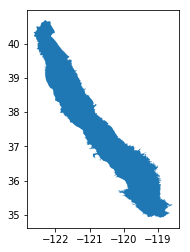

In [151]:
'''
Set the init params:
1) Area: Read from Shapefile
2) Years to analyze: Supplied
3) Scale (optional): Resolution at which to perform analysis
4) Satellites / datasets: Queried from Earth Engine
'''

##### AREA #####

# HUC 4s draining to the CV 
cv = gp.read_file("../shape/cv.shp")
cv2 = cv.geometry.simplify(0.1)
lls = cv2.geometry.iloc[0]
x,y = lls.exterior.coords.xy
coords = [list(zip(x,y))]
area = ee.Geometry.Polygon(coords)
        
##### TIME RANGE #####
years = [x for x in range(2001, 2018)]
months = range(1,13)

##### SCALE #####
cv.plot()

In [114]:
years = range(2001, 2019)
months = range(1,13)
start = datetime.datetime(years[0], 1, 1)
end = datetime.datetime(years[-1]+1, 1, 1)
dt_idx = pd.date_range(start,end, freq='M')

In [115]:

def gen_polys(geometry, dx=0.25, dy=0.25):
    
    '''
    Return ee.ImaceCollection of polygons used to submit full res queries
    '''
    
    bounds = ee.Geometry(geometry).bounds()
    coords = ee.List(bounds.coordinates().get(0))
    ll = ee.List(coords.get(0))
    ur = ee.List(coords.get(2))
    xmin = ll.get(0)
    xmax = ur.get(0)
    ymin = ll.get(1)
    ymax = ur.get(1)

    latlist = ee.List.sequence(ymin, ymax, dx)
    lonlist = ee.List.sequence(xmin, xmax, dy)
    
    polys = []
    
    for lon in lonlist.getInfo():
        for lat in latlist.getInfo():
        
            def make_rect(lat, lon):
                lattemp = ee.Number(lat)
                lontemp = ee.Number(lon)
                uplattemp = lattemp.add(dy)
                lowlontemp = lontemp.add(dx)

                return ee.Feature(ee.Geometry.Polygon([[lontemp, lattemp],[lowlontemp, lattemp],[lowlontemp, uplattemp],[lontemp, uplattemp]]))
            
            poly = make_rect(lat,lon)
            polys.append(poly)
    
    return ee.FeatureCollection(ee.List(polys))

def chunk(dataset,area):
    polys = gen_polys(area)
    d = polys.getInfo()
    results = []
    for i in d['features']:
        aoi = ee.Geometry.Polygon(i['geometry']['coordinates']).intersection(area)
        t = col.filter(ee.Filter.calendarRange(year, year, 'year')).filter(ee.Filter.calendarRange(month, month, 'month')).select(var).filterBounds(aoi).sum()
        t2 = t.multiply(1e-3).multiply(ee.Image.pixelArea()).multiply(scaling_factor).multiply(1e-9)
        # mm to m. m x area = volume. Apply Scaling Factor, Volume in m^3 to km^3
        scale = t2.projection().nominalScale()
        sumdict  = t2.reduceRegion(
            reducer = ee.Reducer.sum(),
            geometry = aoi,
            scale = scale)

        result = sumdict.getInfo()[var]
        results.append(result)
        print('poly complete')
        
    return results



In [116]:
col = data['gldas'][0]
var = data['gldas'][1]
scaling_factor = data['gldas'][2]


In [139]:
def calc_monthly_sum(ImageCollection, var, dates):
    
    '''
    Calculates monthly sum for hourly data. works for GLDAS / NLDAS 
    '''
    
    sums = []
    seq = ee.List.sequence(0, len(dates))
    
    for i in seq.getInfo():
        print(i)
        start = ee.Date('2001-01-01').advance(i, 'month')
        end = start.advance(1, 'month');
        im = ee.ImageCollection(ImageCollection).select(var).filterDate(start, end).sum().set('system:time_start', start.millis())
        ic = im.multiply(1e-3).multiply(im.pixelArea()).multiply(scaling_factor).multiply(1e-9)
        scale = im.projection().nominalScale()
        print(scale.getInfo())
        # mm to m. m x area = volume. Apply Scaling Factor, Volume in m^3 to km^3
        sumdict  = ic.reduceRegion(
            reducer = ee.Reducer.sum(),
            geometry = area,
            scale = scale)
        total = sumdict.getInfo()[var]
        print(total)
        sums.append(total)

    return sums

In [140]:
col = data['gldas'][0]
var = data['gldas'][1]
scaling_factor = data['gldas'][2]

t = calc_monthly_sum(col, "Evap_tavg", dt_idx)

0.0
{'type': 'Image', 'bands': [{'id': 'Evap_tavg', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]}]}
{'type': 'Image', 'bands': [{'id': 'area', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:4326', 'crs_transform': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]}]}
111319.49079327357
0.05824111407799234
1.0
{'type': 'Image', 'bands': [{'id': 'Evap_tavg', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]}]}
{'type': 'Image', 'bands': [{'id': 'area', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:4326', 'crs_transform': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]}]}
111319.49079327357
0.09007342756367241
2.0
{'type': 'Image', 'bands': [{'id': 'Evap_tavg', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]}]}
{'type': 'Image', 'bands': [{'id

KeyboardInterrupt: 

720

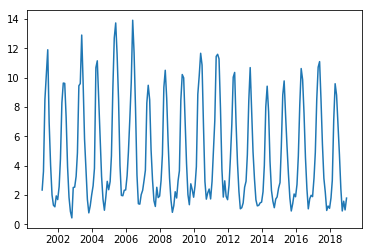

In [111]:
plt.plot(dt_idx, t[:-1])

In [92]:
col = data['nldas'][0]
var = data['nldas'][1]
scaling_factor = data['nldas'][2]

t2 = calc_monthly_sum(data['gldas'])

TypeError: calc_monthly_sum() missing 2 required positional arguments: 'var' and 'dates'

In [171]:
def calc_monthly_sum_t(dataset, years, months):
    
    '''
    Calculates monthly sum for hourly data. works for GLDAS / NLDAS 
    '''
    ImageCollection = dataset[0]
    var = dataset[1]
    scaling_factor = dataset[2]
    
    print(scaling_factor)
        
    period_start = datetime.datetime(years[0], 1, 1)
    start_date = period_start.strftime("%Y-%m-%d")
    period_end = datetime.datetime(years[-1]+1, 1, 1)
    dt_idx = pd.date_range(period_start,period_end, freq='M')
    
    sums = []
    seq = ee.List.sequence(0, len(dt_idx))
    
    for i in seq.getInfo():
        start = ee.Date(start_date).advance(i, 'month')
        end = start.advance(1, 'month');
        im = ee.ImageCollection(ImageCollection).select(var).filterDate(start, end).sum().set('system:time_start', start.millis())
        ic = im.multiply(1e-3).multiply(ee.Image.pixelArea()).multiply(scaling_factor).multiply(1e-9)
        scale = ic.projection().nominalScale()
        
        sumdict  = ic.reduceRegion(
            reducer = ee.Reducer.sum(),
            geometry = area,
            scale = scale)
        total = sumdict.getInfo()[var]
        print(total)
        sums.append(total)

    return sums

In [172]:
asdf = calc_monthly_sum_t(data['nldas'], years, months) # Works as expected

1
3.432338337886061
3.96543815564313
7.493752582103214
9.422009492365806


KeyboardInterrupt: 